## SIMPLE FITTING

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.optimize import curve_fit
from helpers.create_histograms import *
from helpers.visualize_data import *
from helpers.fit_CB import CrystalBall

plt.rcParams.update({'font.size': 12})

In [50]:
def load_histogram(hist_file):
    with np.load(hist_file, "rb") as data:
        bin_edges = data["bin_edges"]
        bin_centers = data["bin_centers"]
        bin_values = data["bin_values"]
        bin_errors = data["bin_errors"]

    return {"centers": bin_centers, "edges": bin_edges, "values": bin_values, "errors": bin_errors}

datadir_input = "data/raw_data/"
datadir_output = "data/generated_histograms/"

# m_mumu energy interval (110.,160.) GeV for Higgs
x_range = (110, 160) # change this!

# if n_bins is an int, it defines the number of equal-width bins in the given range
# if n_bins is a sequence, it defines a monotonically increasing array of bin edges, allowing for non-uniform bin widths
n_bins = 60 # change this!

# filenames of downloaded input .h5 files
dataset_names = ["mc_bkg_new", "mc_sig", "data"]

# labels for file content
labels = ["Background", "Signal", "Data"]

# name of the saved histograms
save_hist_name = "my_hist"

# dictionary from labels to file names
hists_files = {label: f"{datadir_output}{save_hist_name}_{label}.npz" for label in labels}

hists = {}

for hist_label, hist_file in hists_files.items():
    hists[hist_label] = load_histogram(hist_file)

## BACKGROUND FITTIKG

In [51]:
bin_centers, bin_edges, bin_values, bin_errors = hists["Background"].values()
N = len(bin_centers)
print(N)

poly_degs = np.arange(2, 11, 1)
poly_results, reduced_chi2_results = [], []

for deg in poly_degs:
    coef = np.polyfit(bin_centers, bin_values, deg, w=1 / bin_errors)
    poly = np.poly1d(coef)
    
    fit_y = poly(bin_centers)
    poly_results.append(fit_y)
    
    reduced_chi2 = 1 / (N - deg) * np.sum((bin_values - fit_y)**2 / bin_errors**2)
    reduced_chi2_results.append(reduced_chi2)

60


C:\Users\tadej\AppData\Local\Temp\ipykernel_13672\1885500010.py:9: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(bin_centers, bin_values, deg, w=1 / bin_errors)
C:\Users\tadej\AppData\Local\Temp\ipykernel_13672\1885500010.py:9: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(bin_centers, bin_values, deg, w=1 / bin_errors)
C:\Users\tadej\AppData\Local\Temp\ipykernel_13672\1885500010.py:9: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(bin_centers, bin_values, deg, w=1 / bin_errors)
C:\Users\tadej\AppData\Local\Temp\ipykernel_13672\1885500010.py:9: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(bin_centers, bin_values, deg, w=1 / bin_errors)
C:\Users\tadej\AppData\Local\Temp\ipykernel_13672\1885500010.py:9: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(bin_centers, bin_values, deg, w=1 / bin_errors)
C:\Users\tadej\AppData\Local\Temp\ipykernel_13672\1885500010.py:9: RankWarning: Polyfit ma

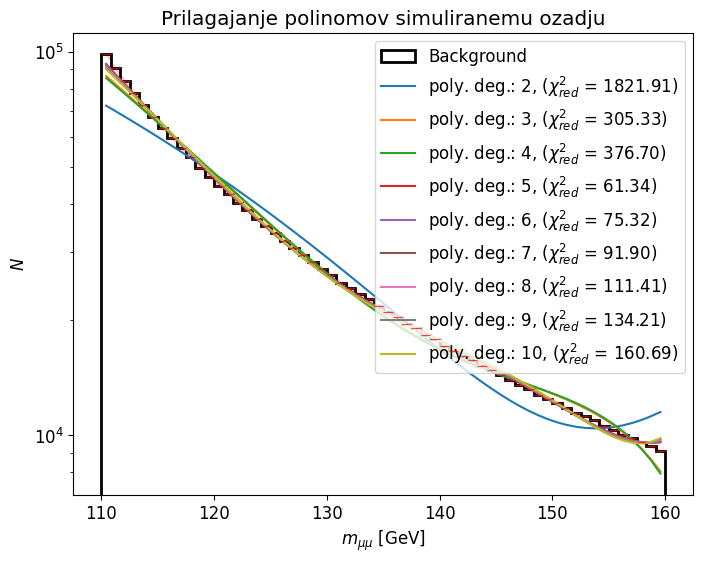

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))

bkg_hist = hists["Background"]
plot_simple_histogram(ax, [bkg_hist["centers"], bkg_hist["edges"], bkg_hist["values"], bkg_hist["errors"]], plot_errs=True, lw=2, color="k", label="Background")

for deg, poly_result, chi2_result in zip(poly_degs, poly_results, reduced_chi2_results):
    ax.plot(bin_centers, poly_result, label=f"poly. deg.: {deg}, ($\\chi^2_{{red}}$ = {chi2_result:.2f})")

ax.set_title('Prilagajanje polinomov simuliranemu ozadju')
ax.set_xlabel(r"$m_{\mu\mu}$ [GeV]")
ax.set_ylabel("$N$")

ax.legend()
ax.set_yscale("log")

In [53]:
def potencna_funkcija(x, a, b):
    return a * x**b


def eksponentna_funkcija(x, a1, a2, b1, b2):
    return a1 * np.exp(-b1*x) + a2 * np.exp(-b2*x)


def dijet_funkcija(x, a, d, c, b1, b2):
    return a * (1 - x**d)**c * x**(b1 + b2 * np.log(x))


def eksponent_polinoma(x, a, b1, b2, b3):
    return a * np.exp(b1 * x + b2 * x**2 + b3 * x**3)


def cms_fit_function(m, a_1, a_2, a_3):
    m_Z, g_Z = 91.1876, 2.4952
    return np.exp(a_2 * m + a_3 * m**2) / ((m - m_Z) ** a_1 + (0.5 * g_Z) ** a_1)

C:\Users\tadej\AppData\Local\Temp\ipykernel_13672\1379816710.py:2: RuntimeWarning: overflow encountered in multiply
  return a * x**b
C:\Users\tadej\AppData\Local\Temp\ipykernel_13672\1379816710.py:10: RuntimeWarning: overflow encountered in power
  return a * (1 - x**d)**c * x**(b1 + b2 * np.log(x))
C:\Users\tadej\AppData\Local\Temp\ipykernel_13672\1379816710.py:10: RuntimeWarning: invalid value encountered in power
  return a * (1 - x**d)**c * x**(b1 + b2 * np.log(x))
C:\Users\tadej\AppData\Local\Temp\ipykernel_13672\3071552626.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_dijet, pcov_dijet = curve_fit(dijet_funkcija, xdata, ydata, sigma=yerrors,


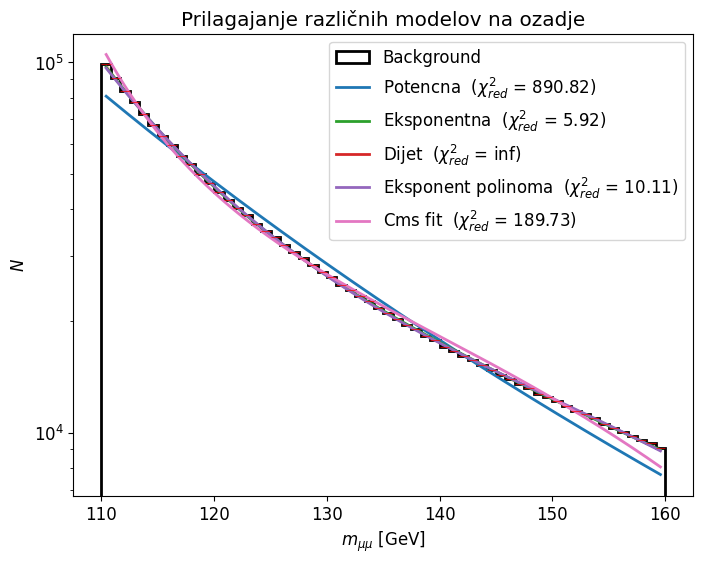

In [54]:
# === Pridobimo podatke iz histograma ===
xdata = bkg_hist["centers"]
ydata = bkg_hist["values"]
yerrors = bkg_hist["errors"]

# === Fit za posamezne funkcije ===
fits = {}

# Potenčna
popt_pot, pcov_pot = curve_fit(potencna_funkcija, xdata, ydata, sigma=yerrors, p0=[1e5, -2])
fits["Potencna"] = (popt_pot, potencna_funkcija)

# Eksponentna (vsota treh)
popt_exp, pcov_exp = curve_fit(eksponentna_funkcija, xdata, ydata, sigma=yerrors,
                               p0=[1e5, 1e5, 0.01, 0.01],
                               maxfev=100000)
fits["Eksponentna"] = (popt_exp, eksponentna_funkcija)

# Dijet
popt_dijet, pcov_dijet = curve_fit(dijet_funkcija, xdata, ydata, sigma=yerrors,
                                   p0=[1e3, 0.1, 100, 100, 100], maxfev=10000)
fits["Dijet"] = (popt_dijet, dijet_funkcija)

# Eksponent polinoma
popt_exppoly, pcov_exppoly = curve_fit(eksponent_polinoma, xdata, ydata, sigma=yerrors,
                                       p0=[1e5, -0.01, 1e-5, -1e-8],
                                       maxfev=10000)
fits["Eksponent polinoma"] = (popt_exppoly, eksponent_polinoma)

# CMS fit function
popt_cms, pcov_cms = curve_fit(cms_fit_function, xdata, ydata, sigma=yerrors,
                                       p0=np.array([1.0, 1.0, 1.0]) * 1e-3,
                                       maxfev=10000)
fits["Cms fit"] = (popt_cms, cms_fit_function)


# === Izračun χ²_reduced za vsakega ===
chi2_values = {}
for name, (params, func) in fits.items():
    y_model = func(xdata, *params)
    chi2 = np.sum(((ydata - y_model) / yerrors) ** 2)
    dof = len(ydata) - len(params)
    chi2_red = chi2 / dof if dof > 0 else np.nan
    chi2_values[name] = chi2_red


# === Risanje ===
fig, ax = plt.subplots(figsize=(8, 6))

# Histogram
plot_simple_histogram(ax, [bkg_hist["centers"], bkg_hist["edges"], bkg_hist["values"], 0.01], plot_errs=True,
                      lw=2, color="k", label="Background")
ax.set_yscale("log")
ax.set_xlabel(r"$m_{\mu\mu}$ [GeV]")
ax.set_ylabel("$N$")
ax.set_title("Prilagajanje različnih modelov na ozadje")

# Narišemo vse fite
x_fit = np.linspace(np.min(xdata), np.max(xdata), 1000)

colors = {
    "Potencna": "tab:blue",
    "Eksponentna": "tab:green",
    "Dijet": "tab:red",
    "Eksponent polinoma": "tab:purple",
    "Cms fit": "tab:pink",
}

for name, (params, func) in fits.items():
    y_fit = func(x_fit, *params)
    chi2_red = chi2_values[name]
    ax.plot(x_fit, y_fit, color=colors[name], lw=2,
            label=f"{name}  ($\\chi^2_{{red}}$ = {chi2_red:.2f})")

ax.legend()
plt.show()

C:\Users\tadej\AppData\Local\Temp\ipykernel_13672\124708208.py:23: RankWarning: Polyfit may be poorly conditioned
  poly_coeffs = np.polyfit(xdata, ydata, deg=5)


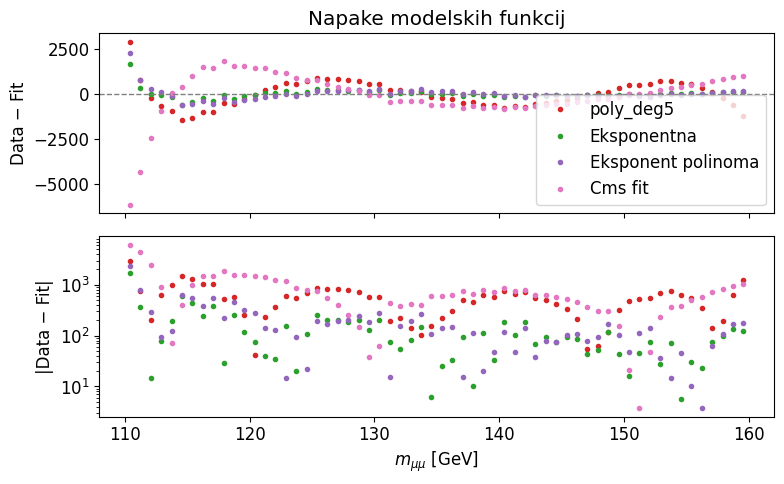

In [55]:
# === Izberi modele, ki jih želiš prikazati v rezidualih ===
selected_models = ["poly_deg5", "Eksponentna", "Eksponent polinoma", "Cms fit"]

# === Glavni histogram ===
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 5), sharex=True,
    gridspec_kw={"height_ratios": [2, 2]}
)

x_fit = np.linspace(np.min(xdata), np.max(xdata), 1000)

colors = {
    "poly_deg5": "tab:red",
    "Eksponentna": "tab:green",
    "Eksponent polinoma": "tab:purple",
    "Cms fit": "tab:pink",
}

# --- Najprej nariši glavne fite ---
for name, color in colors.items():
    if name == "poly_deg5":
        # Tvoj polinom 5. stopnje
        poly_coeffs = np.polyfit(xdata, ydata, deg=5)
        y_fit = np.polyval(poly_coeffs, x_fit)
        chi2_red = np.sum(((ydata - np.polyval(poly_coeffs, xdata)) / yerrors)**2) / (len(ydata) - 6)
    else:
        params, func = fits[name]
        y_fit = func(x_fit, *params)
        chi2_red = chi2_values[name]

# --- Rezidualni graf ---
for name, color in colors.items():
    if name == "poly_deg5":
        y_model = np.polyval(poly_coeffs, xdata)
    else:
        params, func = fits[name]
        y_model = func(xdata, *params)

    residuals = ydata - y_model
    ax1.plot(xdata, residuals, '.', color=color, label=name)
    ax2.plot(xdata, np.abs(residuals), '.', color=color, label=name)

ax1.set_title('Napake modelskih funkcij')
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
ax1.set_ylabel("Data − Fit")
ax1.legend(loc="lower right")

ax2.set_ylabel("|Data − Fit|")
ax2.set_xlabel(r"$m_{\mu\mu}$ [GeV]")
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

## CB NA SIGNAL

In [56]:
bin_centers, bin_edges, bin_values, bin_errors = hists["Signal"].values()

popt, pcov = curve_fit(
    CrystalBall,
    bin_centers,
    bin_values,
    sigma=bin_errors,
    p0=[133.0, 1.5, 1.5, 3.7, 9.6, 124.5, 3.0],
)

std = np.sqrt(np.diag(pcov))
fit_values = CrystalBall(bin_centers, *popt)

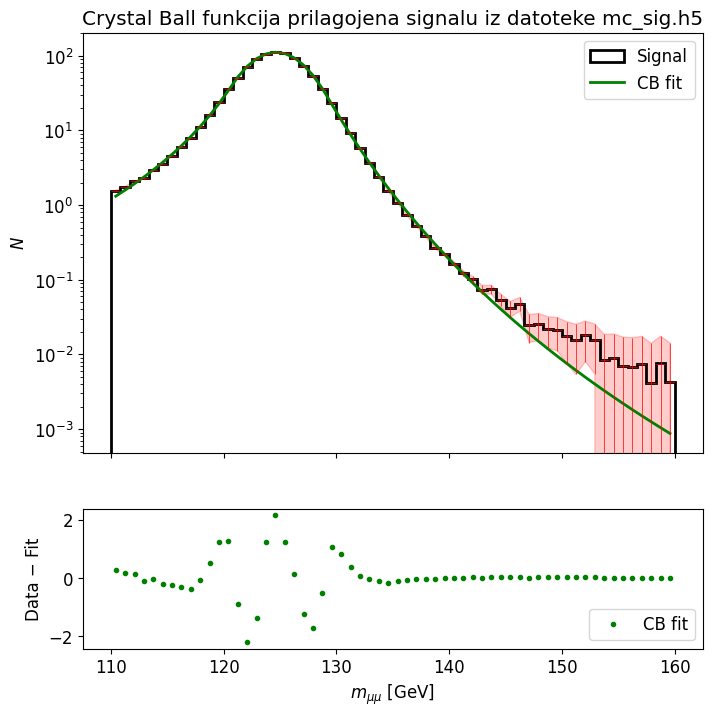

In [57]:
# === Glavni histogram ===
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 8), sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)
plot_simple_histogram(ax1, [bin_centers, bin_edges, bin_values, 0.01], plot_errs=True, lw=2, color="k", label="Signal")
ax1.plot(bin_centers, fit_values, lw=2, color="g", label="CB fit")
ax1.set_ylabel("$N$")
ax1.set_title('Crystal Ball funkcija prilagojena signalu iz datoteke mc_sig.h5')

ax1.legend()
ax1.set_yscale("log")

ax2.plot(bin_centers, bin_values - fit_values, '.', color='green', label='CB fit')
ax2.set_xlabel(r"$m_{\mu\mu}$ [GeV]")
ax2.set_ylabel("Data − Fit")
ax2.legend(loc="lower right")

## FIT NA DEJANSKE PODATKE

In [103]:
def load_histogram(path_to_hist, file_name, label, return_dct=False):
    """Load histogram from .npz file."""

    if label.lower() not in ["background", "signal", "data"]:
        raise ValueError("label must be one of ['Background', 'Signal', 'Data']")

    with np.load(f"{path_to_hist}/{file_name}_{label}.npz", "rb") as data:
        bin_edges = data["bin_edges"]
        bin_centers = data["bin_centers"]
        bin_values = data["bin_values"]
        bin_errors = data["bin_errors"]

    if return_dct:
        return {"centers": bin_centers, "edges": bin_edges, "values": bin_values, "errors": bin_errors}
    else:
        return bin_centers, bin_edges, bin_values, bin_errors

In [104]:
# load already made histograms with some cut on m_mumu
path_to_hist = "data/generated_histograms"
hist_name = "my_hist"
hist_labels = ["Background", "Signal", "Data"]

hists = {}

for hist_label in hist_labels:
    hists[hist_label] = load_histogram(path_to_hist, hist_name, hist_label)

In [105]:
gamma = 10.0 # Napihnemo signal

d_bin_centers, d_bin_edges, d_bin_values, d_bin_errors = hists["Data"]
s_bin_centers, s_bin_edges, s_bin_values, s_bin_errors = hists["Signal"]

hists["AsimovData"] = [
    d_bin_centers,
    d_bin_edges,
    d_bin_values + gamma * s_bin_values,
    np.sqrt(d_bin_errors ** 2 + (gamma * s_bin_errors) ** 2)
]

hists["AsimovSignal"] = [
    s_bin_centers,
    s_bin_edges,
    s_bin_values + gamma * s_bin_values,
    s_bin_errors if gamma == 0.0 else gamma * s_bin_errors,
]

In [106]:
# get histogram data
blind_hists = ["Data", "AsimovData"]

for hist_name in blind_hists:
    bin_centers, bin_edges, bin_values, bin_errors = hists[hist_name]
    
    blind_centers_m = (bin_centers <= 120.0) | (bin_centers >= 130.0) # bool mask for centers
    blind_edges_m = (bin_edges <= 120.0) | (bin_edges > 130.0) # bool mask for edges
    
    # make new dict entry 
    hists[f"Blind{hist_name}"] = [
        bin_centers[blind_centers_m],
        bin_edges[blind_edges_m],
        bin_values[blind_centers_m],
        bin_errors[blind_centers_m],
    ]

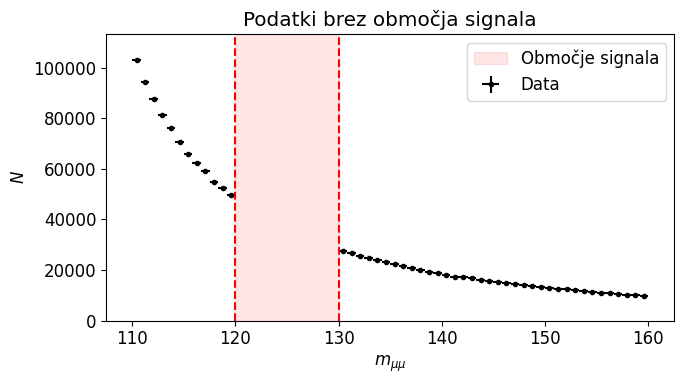

In [107]:
plt.figure(figsize=(7, 4))

centers, edges, values, errors = hists["BlindData"]

plt.errorbar(
    x=centers,
    y=values,
    xerr=np.diff(edges)[0] / 2,
    yerr=errors,
    linestyle="None",
    marker="o",
    ms=3,
    c="k",
    label="Data",
)

plt.axvline(120.0, c="r", ls="--")
plt.axvline(130.0, c="r", ls="--")

max_height = 1.1 * np.max(values)
plt.fill_between([120.0, 130], 0.0, max_height, color="r", alpha=0.1, label="Območje signala")
plt.ylim(0.0, max_height)

plt.title('Podatki brez območja signala')
plt.xlabel(r"$m_{\mu\mu}$")
plt.ylabel(r"$N$")
plt.legend()

plt.tight_layout()

In [108]:
b_bin_centers, b_bin_edges, b_bin_values, b_bin_errors = hists["Background"]
s_bin_centers, s_bin_edges, s_bin_values, s_bin_errors = hists["Signal"]

hists["SignalPlusBackgroundMC"] = [
    b_bin_centers,
    b_bin_edges,
    b_bin_values + s_bin_values,
    np.sqrt(b_bin_errors ** 2 + s_bin_errors ** 2),
]

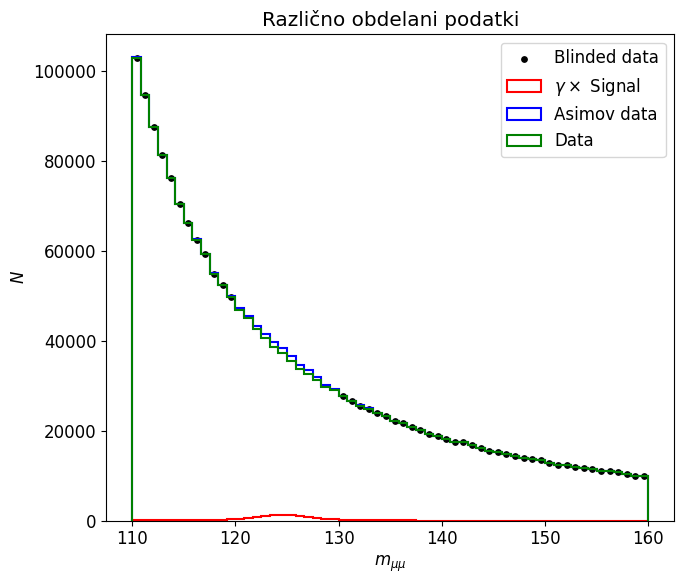

In [109]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.scatter(hists["BlindData"][0], hists["BlindData"][2], c="k", s=15, label="Blinded data")
ax = plot_simple_histogram(ax, hists["AsimovSignal"], color="r", label=r"$\gamma \times$ Signal", lw=1.5)
ax = plot_simple_histogram(ax, hists["AsimovData"], color="b", label="Asimov data", lw=1.5)
ax = plot_simple_histogram(ax, hists["Data"], color="g", label="Data", lw=1.5)

ax.set_title('Različno obdelani podatki')
ax.set_xlabel(r"$m_{\mu\mu}$")
ax.set_ylabel("$N$")
ax.legend()

fig.tight_layout()

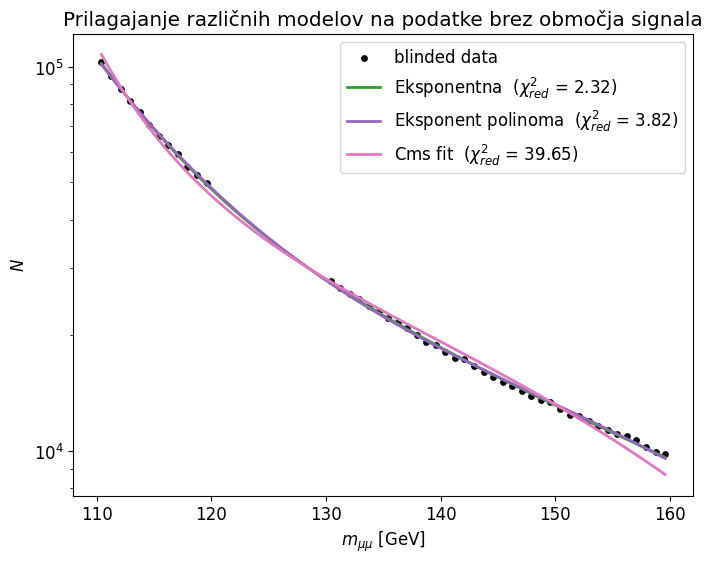

In [110]:
# === Pridobimo podatke iz histograma ===
xdata = hists["BlindData"][0]
ydata = hists["BlindData"][2]
yerrors = hists["BlindData"][3]

# === Fit za posamezne funkcije ===
fits_data = {}

# Eksponentna (vsota treh)
popt_exp, pcov_exp = curve_fit(eksponentna_funkcija, xdata, ydata, sigma=yerrors,
                               p0=[1e5, 1e5, 0.01, 0.01],
                               maxfev=100000)
fits_data["Eksponentna"] = (popt_exp, eksponentna_funkcija)

# Eksponent polinoma
popt_exppoly, pcov_exppoly = curve_fit(eksponent_polinoma, xdata, ydata, sigma=yerrors,
                                       p0=[1e5, -0.01, 1e-5, -1e-8],
                                       maxfev=10000)
fits_data["Eksponent polinoma"] = (popt_exppoly, eksponent_polinoma)

# CMS fit function
popt_cms, pcov_cms = curve_fit(cms_fit_function, xdata, ydata, sigma=yerrors,
                                       p0=np.array([1.0, 1.0, 1.0]) * 1e-3,
                                       maxfev=10000)
fits_data["Cms fit"] = (popt_cms, cms_fit_function)


# === Izračun χ²_reduced za vsakega ===
chi2_values = {}
for name, (params, func) in fits_data.items():
    y_model = func(xdata, *params)
    chi2 = np.sum(((ydata - y_model) / yerrors) ** 2)
    dof = len(ydata) - len(params)
    chi2_red = chi2 / dof if dof > 0 else np.nan
    chi2_values[name] = chi2_red


# === Risanje ===
fig, ax = plt.subplots(figsize=(8, 6))

# Histogram
ax.scatter(hists["BlindData"][0], hists["BlindData"][2], c="k", s=15, label="blinded data")
ax.set_yscale("log")
ax.set_xlabel(r"$m_{\mu\mu}$ [GeV]")
ax.set_ylabel("$N$")
ax.set_title("Prilagajanje različnih modelov na podatke brez območja signala")

# Narišemo vse fite
x_fit = np.linspace(np.min(xdata), np.max(xdata), 1000)

colors = {
    "Potencna": "tab:blue",
    "Eksponentna": "tab:green",
    "Dijet": "tab:red",
    "Eksponent polinoma": "tab:purple",
    "Cms fit": "tab:pink",
}

for name, (params, func) in fits_data.items():
    y_fit = func(x_fit, *params)
    chi2_red = chi2_values[name]
    ax.plot(x_fit, y_fit, color=colors[name], lw=2,
            label=f"{name}  ($\\chi^2_{{red}}$ = {chi2_red:.2f})")

ax.legend()
plt.show()

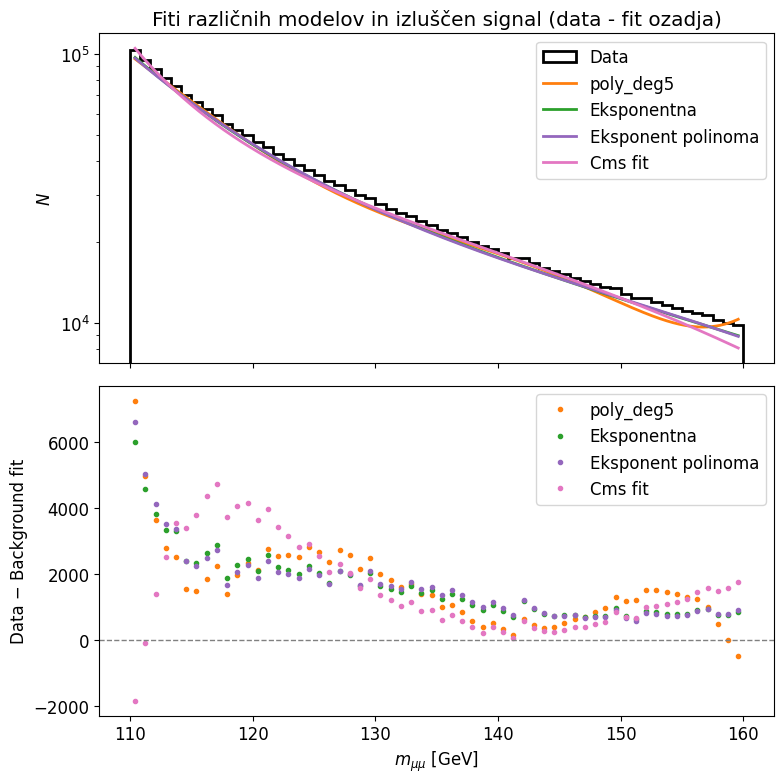

In [111]:
# === Izberi modele, ki jih želiš prikazati v rezidualih ===
selected_models = ["poly_deg5", "Eksponentna", "Eksponent polinoma", "Cms fit"]

# === Glavni histogram ===
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 8), sharex=True,
    gridspec_kw={"height_ratios": [2, 2]}
)

# === Pridobimo podatke iz histograma ===
xdata = hists["Data"][0]
xerrors = hists["Data"][1]
ydata = hists["Data"][2]
yerrors = hists["Data"][3]

# --- Glavni graf ---
plot_simple_histogram(ax1, [xdata, xerrors, ydata, yerrors],
                      lw=2, color="k", label="Data")
ax1.set_yscale("log")
ax1.set_ylabel("$N$")
ax1.set_title("Fiti različnih modelov in izluščen signal (data - fit ozadja)")

x_fit = np.linspace(np.min(xdata), np.max(xdata), 1000)

colors = {
    "poly_deg5": "tab:orange",
    "Eksponentna": "tab:green",
    "Eksponent polinoma": "tab:purple",
    "Cms fit": "tab:pink",
}

# --- Najprej nariši glavne fite ---
for name, color in colors.items():
    if name == "poly_deg5":
        # Tvoj polinom 5. stopnje
        y_fit = np.polyval(poly_coeffs, x_fit)
        chi2_red = np.sum(((ydata - np.polyval(poly_coeffs, xdata)) / yerrors)**2) / (len(ydata) - 6)
    else:
        params, func = fits[name]
        y_fit = func(x_fit, *params)
        chi2_red = chi2_values[name]

    ax1.plot(x_fit, y_fit, color=color, lw=2,
             label=f"{name}")

ax1.legend(loc="upper right")

# --- Rezidualni graf ---
for name, color in colors.items():
    if name == "poly_deg5":
        y_model = np.polyval(poly_coeffs, xdata)
    else:
        params, func = fits[name]
        y_model = func(xdata, *params)

    residuals = ydata - y_model
    ax2.plot(xdata, residuals, '.', color=color, label=name)

ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
ax2.set_xlabel(r"$m_{\mu\mu}$ [GeV]")
ax2.set_ylabel("Data − Background fit")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


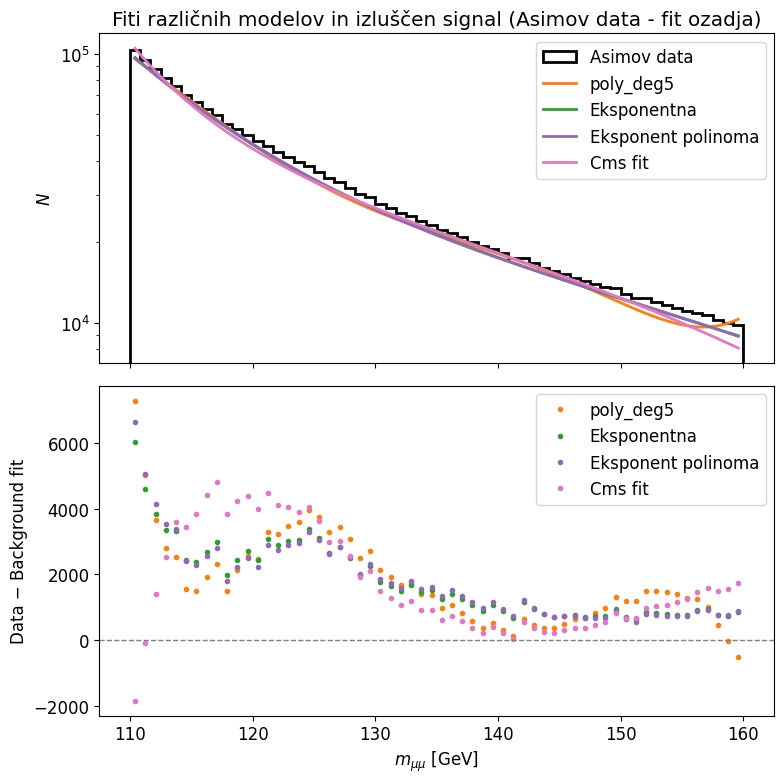

In [112]:
# === Izberi modele, ki jih želiš prikazati v rezidualih ===
selected_models = ["poly_deg5", "Eksponentna", "Eksponent polinoma", "Cms fit"]

# === Glavni histogram ===
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 8), sharex=True,
    gridspec_kw={"height_ratios": [2, 2]}
)

# === Pridobimo podatke iz histograma ===
xdata = hists["AsimovData"][0]
xerrors = hists["AsimovData"][1]
ydata = hists["AsimovData"][2]
yerrors = hists["AsimovData"][3]

# --- Glavni graf ---
plot_simple_histogram(ax1, [xdata, xerrors, ydata, yerrors],
                      lw=2, color="k", label="Asimov data")
ax1.set_yscale("log")
ax1.set_ylabel("$N$")
ax1.set_title("Fiti različnih modelov in izluščen signal (Asimov data - fit ozadja)")

x_fit = np.linspace(np.min(xdata), np.max(xdata), 1000)

colors = {
    "poly_deg5": "tab:orange",
    "Eksponentna": "tab:green",
    "Eksponent polinoma": "tab:purple",
    "Cms fit": "tab:pink",
}

# --- Najprej nariši glavne fite ---
for name, color in colors.items():
    if name == "poly_deg5":
        # Tvoj polinom 5. stopnje
        y_fit = np.polyval(poly_coeffs, x_fit)
        chi2_red = np.sum(((ydata - np.polyval(poly_coeffs, xdata)) / yerrors)**2) / (len(ydata) - 6)
    else:
        params, func = fits[name]
        y_fit = func(x_fit, *params)
        chi2_red = chi2_values[name]

    ax1.plot(x_fit, y_fit, color=color, lw=2,
             label=f"{name}")

ax1.legend(loc="upper right")

# --- Rezidualni graf ---
for name, color in colors.items():
    if name == "poly_deg5":
        y_model = np.polyval(poly_coeffs, xdata)
    else:
        params, func = fits[name]
        y_model = func(xdata, *params)

    residuals = ydata - y_model
    ax2.plot(xdata, residuals, '.', color=color, label=name)

ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
ax2.set_xlabel(r"$m_{\mu\mu}$ [GeV]")
ax2.set_ylabel("Data − Background fit")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [113]:
# === Pridobimo podatke iz histograma ===
xdata = hists["AsimovData"][0]
xerrors = hists["AsimovData"][1]
ydata = hists["AsimovData"][2]
yerrors = hists["AsimovData"][3]

CBs = {}
residuals_dict = {}

for model in selected_models:
    print(model)
    if model == "poly_deg5":
        y_model = np.polyval(poly_coeffs, xdata)
    else:
        params, func = fits[model]
        y_model = func(xdata, *params)

    residuals = ydata - y_model

    popt, pcov = curve_fit(
        CrystalBall,
        xdata,
        residuals,
        sigma=yerrors,
        p0=[133.0, 1.5, 1.5, 3.7, 9.6, 124.5, 3.0],
        maxfev=200000
    )

    fit_values = CrystalBall(bin_centers, *popt)

    residuals_dict[f'{model}'] = residuals
    CBs[f'{model}'] = fit_values

poly_deg5
Eksponentna


C:\Users\tadej\AppData\Local\Temp\ipykernel_13672\254980157.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(


Eksponent polinoma
Cms fit


Text(0, 0.5, '$N$')

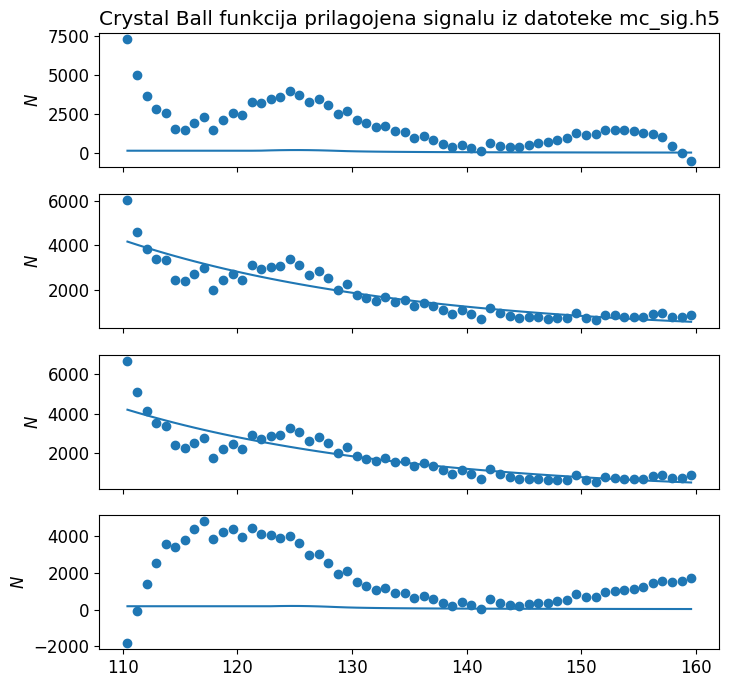

In [114]:
# === Glavni histogram ===
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows=4, ncols=1, figsize=(8, 8), sharex=True
)

ax1.plot(xdata, CBs['poly_deg5'])
ax1.scatter(xdata, residuals_dict['poly_deg5'])
ax1.set_ylabel("$N$")
ax1.set_title('Crystal Ball funkcija prilagojena signalu iz datoteke mc_sig.h5')

ax2.plot(xdata, CBs['Eksponentna'])
ax2.scatter(xdata, residuals_dict['Eksponentna'])
ax2.set_ylabel("$N$")

ax3.plot(xdata, CBs['Eksponent polinoma'])
ax3.scatter(xdata, residuals_dict['Eksponent polinoma'])
ax3.set_ylabel("$N$")

ax4.plot(xdata, CBs['Cms fit'])
ax4.scatter(xdata, residuals_dict['Cms fit'])
ax4.set_ylabel("$N$")